In [138]:
import pandas as pd  # For data handling
import numpy as np   # For numerical computations
from plotnine import *  # For visualizations (ggplot2-style)
import xgboost as xgb # For XGBoost
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
)
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm  # progress bar
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from joblib import parallel_backend
from tqdm_joblib import tqdm_joblib

In [139]:
# Loading Alzheimers dataset
pd.set_option('display.max_columns', None)
df = pd.read_csv('alzheimers_disease_data (1).csv')
display(df.head())
print(f"Shape of df: {df.shape}")

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,Diabetes,Depression,HeadInjury,Hypertension,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,0,0,1,1,0,0,142,72,242.366840,56.150897,33.682563,162.189143,21.463532,6.518877,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,0,0,0,0,0,0,115,64,231.162595,193.407996,79.028477,294.630909,20.613267,7.118696,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,1,0,0,0,0,0,99,116,284.181858,153.322762,69.772292,83.638324,7.356249,5.895077,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,0,0,0,0,0,0,118,115,159.582240,65.366637,68.457491,277.577358,13.991127,8.965106,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,0,0,0,0,0,0,94,117,237.602184,92.869700,56.874305,291.198780,13.517609,6.045039,0,0,0.014691,0,0,1,1,0,0,XXXConfid


Shape of df: (2149, 35)


In [140]:
#Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

PatientID                    0
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTasks    0
Forgetfu

In [141]:
#Drop non-predicting columns
df = df.drop(columns=['PatientID', 'DoctorInCharge'])
print(f"Shape of df: {df.shape}")

Shape of df: (2149, 33)


In [142]:
#Defining features and target
X = df.drop(columns=('Diagnosis'))
y = df['Diagnosis']

In [ ]:
#Train/test split
x_train, x_test, y_train, y_test = train_test_split(
   X, y, test_size = 0.2, stratify=y, random_state=42 # 20% of data goes to test, stratify preserves class proportions, important for imbalanced data
)

#Pipeline

pipe = Pipeline([  #chains steps 
    ("scaler", StandardScaler()),   #standardizes numeric features, fitted on training data, applied to test
    ("logreg", LogisticRegression(max_iter=1000, class_weight="balanced"))  # logreg classifiier, weighs classes inversely to frequency

])

#Fitting models
pipe.fit(x_train, y_train)  

#Evaluate
print("Train accuracy:", pipe.score(x_train, y_train))
print("Test accuracy:", pipe.score(x_test, y_test))

#Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)   #5 fold cross validation that maintains class proportions. Randomizes fold assignments
scores = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc") #uses full dataset, pipeline, and auc to evaluate scores.
print("Cross-Validated AUC:", scores.mean())


Train accuracy: 0.8336242001163467
Test accuracy: 0.8162790697674419
Cross-Validated AUC: 0.8979279297443672



Confusion matrix:


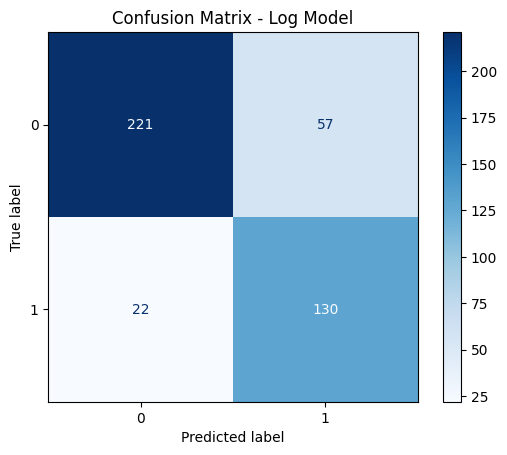


Accuracy:
0.8162790697674419
              precision    recall  f1-score   support

           0       0.91      0.79      0.85       278
           1       0.70      0.86      0.77       152

    accuracy                           0.82       430
   macro avg       0.80      0.83      0.81       430
weighted avg       0.83      0.82      0.82       430



In [ ]:
#using our logistic model to predict outcomes
y_pred = pipe.predict(x_test)


#plotting confusion matrix
print("\nConfusion matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Log Model")
plt.show()
print("\nAccuracy:")
print(accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

#Decision Tree Model


In [ ]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)  #decision tree classifier 5-level tree
dt.fit(x_train, y_train)  #fitting tree on training data
y_pred_dt = dt.predict(x_test)  #applying tree to test data, creating outcomes


print("\nDecision Tree")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))  #comparing dt outcomes to actual
print("ROC AUC:", roc_auc_score(y_test, dt.predict_proba(x_test)[:,1]))
print(classification_report(y_test, y_pred_dt))



Decision Tree
Accuracy: 0.9232558139534883
ROC AUC: 0.9090661681181371
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       278
           1       0.88      0.90      0.89       152

    accuracy                           0.92       430
   macro avg       0.91      0.92      0.92       430
weighted avg       0.92      0.92      0.92       430




Confusion matrix:


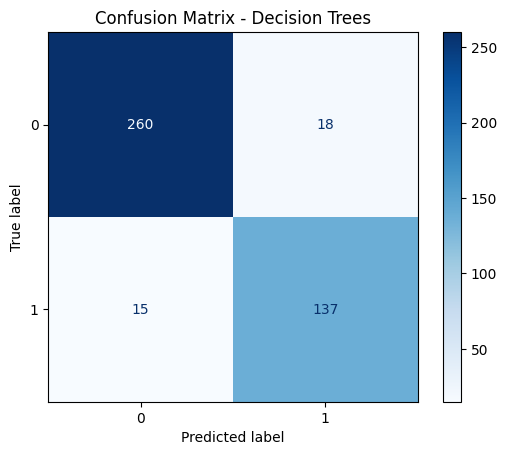


Accuracy:
0.9232558139534883
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       278
           1       0.88      0.90      0.89       152

    accuracy                           0.92       430
   macro avg       0.91      0.92      0.92       430
weighted avg       0.92      0.92      0.92       430



In [ ]:

#printing confusion matrix
print("\nConfusion matrix:")
cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Decision Trees")
plt.show()
print("\nAccuracy:")
print(accuracy_score(y_test, y_pred_dt))

print(classification_report(y_test, y_pred_dt))

#Random Forest

In [ ]:
#random forest model with 200 trees
rf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, class_weight="balanced")
rf.fit(x_train, y_train)  #fitting model
y_pred_rf = rf.predict(x_test)  #creating outcomes

print("\n Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))  #compaing outcomes to actual
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(x_test)[0:,1]))
print(classification_report(y_test, y_pred_rf))


 Random Forest
Accuracy: 0.9348837209302325
ROC AUC: 0.9430258424839076
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       278
           1       0.94      0.87      0.90       152

    accuracy                           0.93       430
   macro avg       0.94      0.92      0.93       430
weighted avg       0.94      0.93      0.93       430




Confusion matrix:


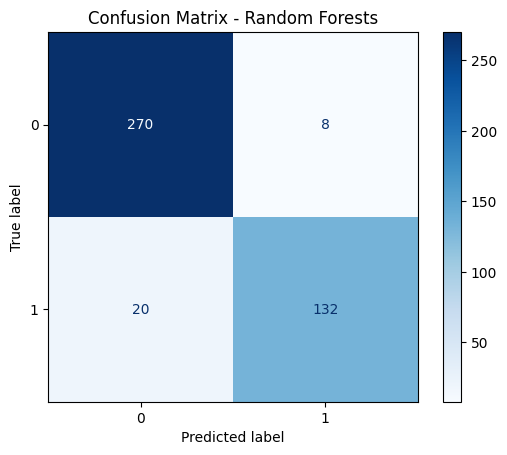


Accuracy:
0.9348837209302325
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       278
           1       0.94      0.87      0.90       152

    accuracy                           0.93       430
   macro avg       0.94      0.92      0.93       430
weighted avg       0.94      0.93      0.93       430



In [ ]:

#print confusion matrix
print("\nConfusion matrix:")
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forests")
plt.show()
print("\nAccuracy:")
print(accuracy_score(y_test, y_pred_rf))

print(classification_report(y_test, y_pred_rf))

XGBoost Model

In [ ]:
xgb = XGBClassifier(  #xgb model
    n_estimators=300,  #number of trees
    learning_rate=0.05, #slower, more conservative steps
    max_depth=3,  #depth of each tree, reduct overfitting
    subsample=0.8,  #each tree trains on random sample of 80% of data
    colsample_bytree=0.8, #each tree sees only 80% of features
    eval_metric="logloss",  #logloss measures probability quality
    random_state=42
)
xgb.fit(x_train, y_train)  #training
y_pred_xgb = xgb.predict(x_test)  #implimenting

print("\n XGBoost")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))  #comparing
print("Roc AUC:", roc_auc_score(y_test, xgb.predict_proba(x_test)[:, 1]))
print(classification_report(y_test, y_pred_xgb))


 XGBoost
Accuracy: 0.9465116279069767
Roc AUC: 0.9424697084437713
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       278
           1       0.93      0.91      0.92       152

    accuracy                           0.95       430
   macro avg       0.94      0.94      0.94       430
weighted avg       0.95      0.95      0.95       430




Confusion matrix:


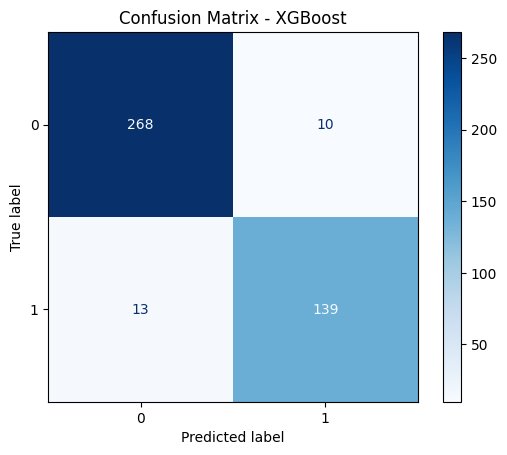


Accuracy:
0.9465116279069767
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       278
           1       0.93      0.91      0.92       152

    accuracy                           0.95       430
   macro avg       0.94      0.94      0.94       430
weighted avg       0.95      0.95      0.95       430



In [ ]:
#confusion matrix
print("\nConfusion matrix:")
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.show()
print("\nAccuracy:")
print(accuracy_score(y_test, y_pred_xgb))

print(classification_report(y_test, y_pred_xgb))

#Cross Validation


In [ ]:
#comparing cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for model, name in [(dt, "Decision Trees"), (rf, "Random Forests"), (xgb, "XGBoost")]:
  cv_scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
  print(f"{name}, CV AUC: {cv_scores.mean():.3f}")

Decision Trees, CV AUC: 0.936
Random Forests, CV AUC: 0.951
XGBoost, CV AUC: 0.952


#ROC

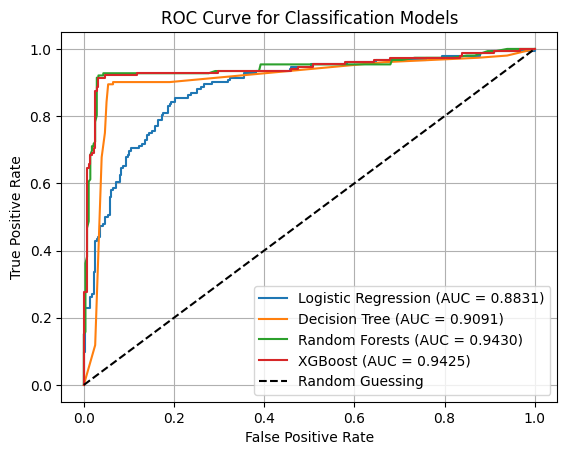

In [ ]:
#comparing ROC and AUC

#predicted probabilities
y_pred_proba_logreg = pipe.predict_proba(x_test)[:, 1]
y_pred_proba_dt = dt.predict_proba(x_test)[:, 1]
y_pred_proba_rf = rf.predict_proba(x_test)[:, 1]
y_pred_proba_xgb = xgb.predict_proba(x_test)[:, 1]


#Calc ROC and AUC
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_proba_logreg)
auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

#Plot
plt.figure()
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.4f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forests (AUC = {auc_rf:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})')

plt.plot([0,1], [0,1], 'k--', label="Random Guessing")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classification Models')
plt.legend()
plt.grid(True)
plt.show()

XGBoost is the best performing model. Below we will tune it to hopefully acheive better accuracy.

In [ ]:
#parameter grid for XGBoost

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.3], # learning rate
    'max_depth': [4, 5, 6], # tree complexity
    'subsample': [1], # no subsampling
    'colsample_bytree': [1], # no column sampling
    'min_child_weight': [1, 3, 5, 7], # minimum instance weight
    'gamma': [0, 0.1, 0.2] # minimum loss reduction
}

#base XGB Classifier
xgb_tuning = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False #suppresses old label encoder behavior
)

#Cross Val
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


#calc total combinations
total_combos = 1
for param_values in param_grid.values():
    total_combos *=len(param_values)


print("Starting Grid Search")


#with tqdm_joblib(tqdm(desc="XBGoost Grid Search", total=total_combos * 5)) as progress_bar:
    

grid_search = GridSearchCV(  #tries every combo
            estimator=xgb_tuning,  #base model
            param_grid=param_grid, #parameters
            scoring='roc_auc',   #uses roc auc on cv to score
            cv=cv,
            n_jobs=-1, # use all cpu cores
            verbose=2 # prints progress
        )

grid_search.fit(x_train, y_train) # runs all fits


best_params = grid_search.best_params_   #hyperparameters with the highest mean CV score.
best_scores = grid_search.best_score_ #mean ROC AUC for that combo across folds.

print("Best Parameters:", best_params)
print("Best Score:", best_scores)

Starting Grid Search
Fitting 5 folds for each of 900 candidates, totalling 4500 fits


c:\Users\patbe\Machine Leaning Project\ml_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:52:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Best Parameters: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1}
Best Score: 0.9603010643135482


In [ ]:
# Get the best estimator and extract n_estimators
best_estimator = grid_search.best_estimator_  #fitted model with best hyperparameters
best_rounds = best_estimator.get_params()['n_estimators']  #best round

print("Best Estimator:", best_estimator)
print("Best Rounds (n_estimators):", best_rounds)

Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)
Best Rounds (n_estimators): 300


In [ ]:
final_xgb_tuned = XGBClassifier(   #final xgb model
    **best_params,   #using tuned parameters
    eval_metric='logloss',  #monitor logloss
    use_label_encoder=False,   #
    random_state=42   #reproducability
)  

final_xgb_tuned.fit(x_train, y_train)   #trains model on training set

y_pred_tuned = final_xgb_tuned.predict(x_test)   #applies model to predict outcomes
y_pred_proba_tuned = final_xgb_tuned.predict_proba(x_test)[:, 1]  #grabs positive class probabilities
 
print("Test Accuracy:", accuracy_score(y_test, y_pred_tuned))  #compares accuracy
print("Test ROC AUC:", roc_auc_score(y_test, y_pred_proba_tuned)) #compares roc
print(classification_report(y_test, y_pred_tuned))

c:\Users\patbe\Machine Leaning Project\ml_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:52:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encode" } are not used.



Test Accuracy: 0.9488372093023256
Test ROC AUC: 0.9416650889814464
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       278
           1       0.94      0.91      0.93       152

    accuracy                           0.95       430
   macro avg       0.95      0.94      0.94       430
weighted avg       0.95      0.95      0.95       430




Confusion matrix:


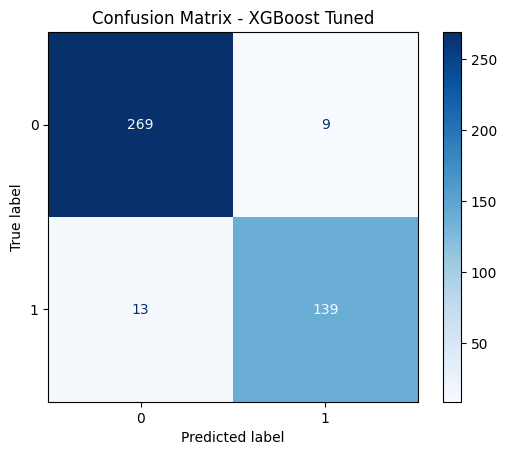


Accuracy:
0.9488372093023256


In [ ]:
#confusion matrix
print("\nConfusion matrix:")
cm = confusion_matrix(y_test, y_pred_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost Tuned")
plt.show()
print("\nAccuracy:")
print(accuracy_score(y_test, y_pred_tuned))

#New ROC Curve

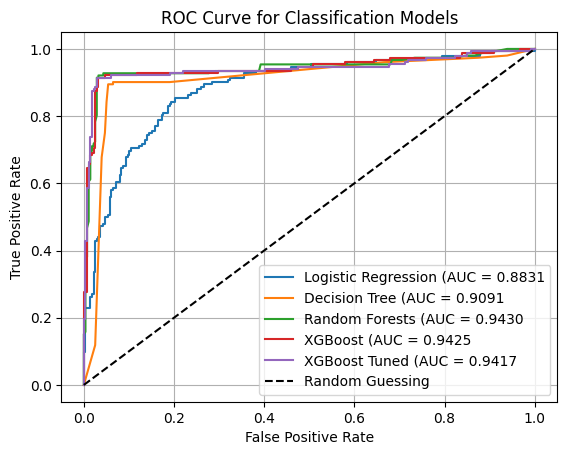

In [226]:

fpr_xgb_tuned, tpr_xgb_tuned, _ = roc_curve(y_test, y_pred_proba_tuned)  #finds false positive and true positive rates for tuned xgb
auc_xgb_tuned = roc_auc_score(y_test, y_pred_proba_tuned)  #tuned xgb roc auc

#storing accuracies for each model
acc_logreg = accuracy_score(y_test, pipe.predict(x_test))
acc_dt = accuracy_score(y_test, y_pred_dt)
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
acc_xgb_tuned = accuracy_score(y_test, y_pred_tuned)


#Plotting roc with accuracy and auc labels
plt.figure()
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.4f}')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.4f}')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forests (AUC = {auc_rf:.4f}')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f}')
plt.plot(fpr_xgb_tuned, tpr_xgb_tuned, label=f'XGBoost Tuned (AUC = {auc_xgb_tuned:.4f}')


plt.plot([0,1], [0,1], 'k--', label="Random Guessing")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classification Models')
plt.legend()
plt.grid(True)
plt.show()

#Feature Importance

In [ ]:
import pandas as pd

importances = final_xgb_tuned.feature_importances_  #feature importance scores

feat_imp = pd.DataFrame({  #creating data frame
    "Feature": X.columns,  #each column name
    "Importance": importances  #its importance score
}).sort_values(by="Importance", ascending=False)  #sorted  by most important first

feat_imp.head(10)



,Feature,Importance
24,MemoryComplaints,0.158793
22,MMSE,0.133810
26,ADL,0.122330
23,FunctionalAssessment,0.121076
25,BehavioralProblems,0.114240
13,Depression,0.020906
9,SleepQuality,0.018023
18,CholesterolTotal,0.017388
20,CholesterolHDL,0.016464
16,SystolicBP,0.016192


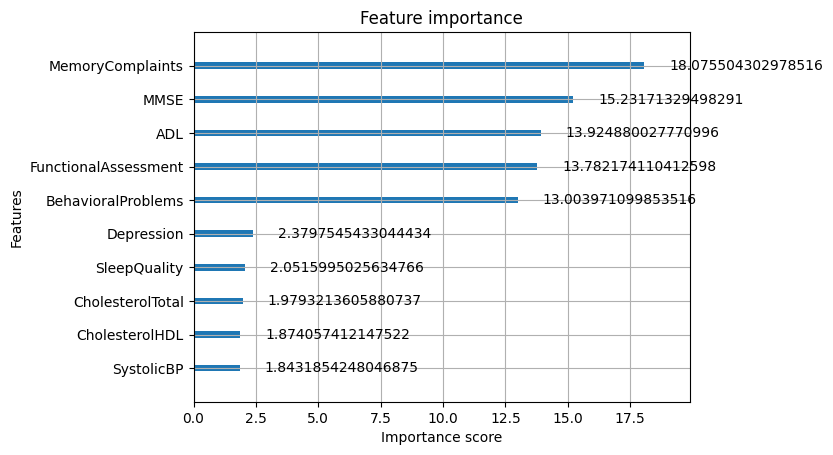

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt


#plotting feature importance
plot_importance(final_xgb_tuned, importance_type="gain", max_num_features=10) #ranks features by average gain they provide when used in splits
plt.show()


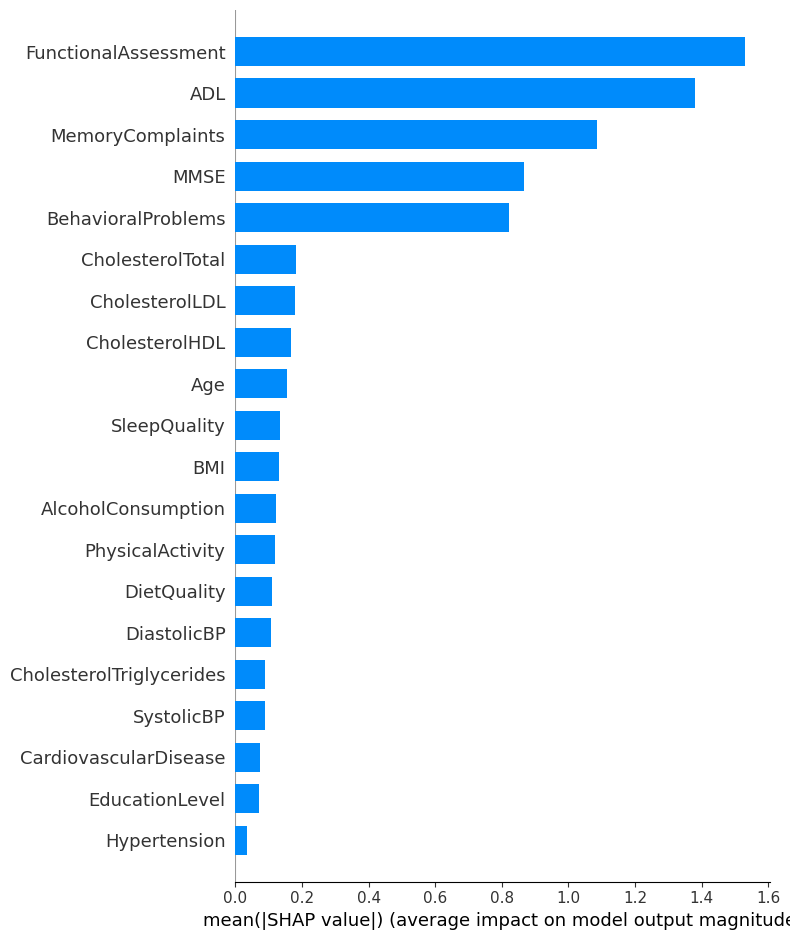

In [ ]:
import shap

explainer = shap.TreeExplainer(final_xgb_tuned)   #tree specific explainer
shap_values = explainer.shap_values(x_train)  #shap values for each row in x_train. How much did feature push model output up or down?

shap.summary_plot(shap_values, x_train, plot_type="bar")

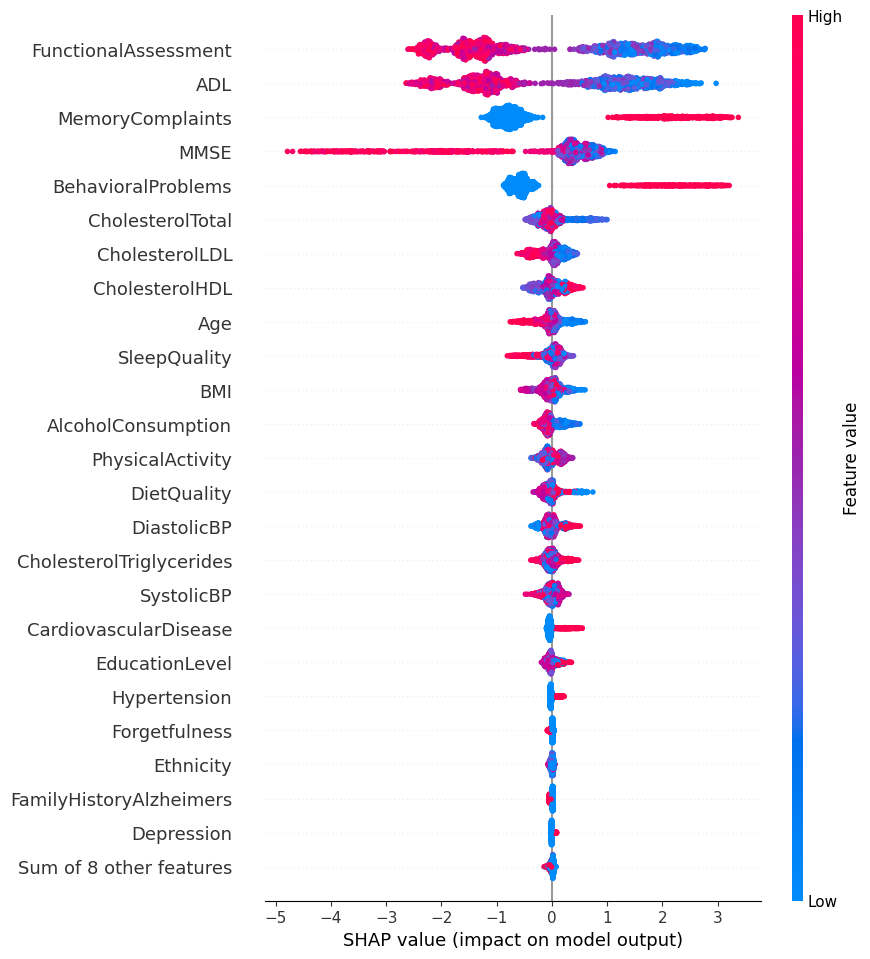

In [161]:

explainer = shap.TreeExplainer(final_xgb_tuned)
shap_values = explainer(x_train)

# Interactive JS init
shap.initjs()

# Beeswarm for binary
shap.plots.beeswarm(shap_values, max_display=25)  # matplotlib figure

Creating and Training Model for Synthetic Variable Creation    

In [238]:
#Loading Tech Dataset
tech_df = pd.read_csv('Tech_Use_Stress_Wellness.csv')
tech_df

,user_id,age,gender,daily_screen_time_hours,phone_usage_hours,laptop_usage_hours,tablet_usage_hours,tv_usage_hours,social_media_hours,work_related_hours,entertainment_hours,gaming_hours,sleep_duration_hours,sleep_quality,mood_rating,stress_level,physical_activity_hours_per_week,location_type,mental_health_score,uses_wellness_apps,eats_healthy,caffeine_intake_mg_per_day,weekly_anxiety_score,weekly_depression_score,mindfulness_minutes_per_day
0,1,53,Male,6.8,2.9,2.1,0.5,2.0,2.3,3.0,2.3,2.2,7.1,4.0,5.6,3,4.4,Rural,79.0,True,True,150.4,7.0,3.0,14.0
1,2,66,Female,4.1,2.1,1.6,0.4,0.8,2.8,3.5,2.0,1.6,6.8,4.0,6.0,4,4.1,Rural,71.0,True,True,124.1,7.0,10.0,15.5
2,3,43,Male,4.7,3.6,0.0,0.5,1.4,3.7,3.6,1.0,0.9,6.0,4.0,4.3,6,1.4,Urban,67.0,True,True,218.3,11.0,7.0,19.5
3,4,29,Female,6.0,4.5,0.0,0.2,1.3,4.5,4.0,0.8,0.3,7.3,4.0,1.3,10,0.0,Rural,55.0,True,True,133.7,17.0,14.0,13.9
4,5,57,Male,6.7,3.4,2.0,0.8,1.2,3.8,3.5,1.2,2.0,7.0,4.0,3.6,6,2.8,Urban,62.0,False,False,192.8,5.0,8.0,26.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,17,Female,7.0,2.2,0.9,0.5,2.3,4.5,4.1,1.3,1.1,5.9,4.0,1.0,10,0.0,Rural,55.0,False,False,233.0,18.0,16.0,11.8
4996,4997,42,Female,1.9,1.5,1.5,0.2,0.0,1.7,2.7,2.7,2.5,8.2,4.0,7.7,2,5.3,Rural,79.0,False,True,159.3,2.0,1.0,13.0
4997,4998,20,Female,6.3,1.5,2.6,0.6,0.8,4.5,3.9,1.4,1.0,7.7,4.0,1.0,10,0.1,Rural,47.0,False,False,83.0,12.0,17.0,9.1
4998,4999,58,Male,6.2,3.5,1.2,1.3,1.3,3.8,3.7,1.3,1.7,7.6,3.0,6.7,5,4.3,Urban,76.0,False,False,108.0,6.0,7.0,16.0


#Similar Columns in Alz and Tech Datasets

Physical Activity

Diet Quality

Sleep Quality

Depression

Age

Gender

In [239]:
#Extracting Similar Variables
tech_similar_cols = ['age', 'gender', 'physical_activity_hours_per_week', 'eats_healthy', 'sleep_quality', 'weekly_depression_score', 'stress_level']

tech_similar_df = tech_df[tech_similar_cols].copy()  #df with similar columns
tech_similar_df['eats_healthy'] = tech_similar_df['eats_healthy'].astype(int)  #ensuring eats_healthy is binary
tech_similar_df['gender'] = tech_similar_df['gender'].map({'Male': True, 'Female': False}) #true or false values for gender
tech_similar_df = tech_similar_df.dropna(subset=['gender'])  #drop rows where gender is not male or female

tech_similar_df['gender'] = tech_similar_df['gender'].astype(int)  #binary values for gender
tech_similar_df

,age,gender,physical_activity_hours_per_week,eats_healthy,sleep_quality,weekly_depression_score,stress_level
0,53,1,4.4,1,4.0,3.0,3
1,66,0,4.1,1,4.0,10.0,4
2,43,1,1.4,1,4.0,7.0,6
3,29,0,0.0,1,4.0,14.0,10
4,57,1,2.8,0,4.0,8.0,6
...,...,...,...,...,...,...,...
4995,17,0,0.0,0,4.0,16.0,10
4996,42,0,5.3,1,4.0,1.0,2
4997,20,0,0.1,0,4.0,17.0,10
4998,58,1,4.3,0,3.0,7.0,5


In [240]:
#scale columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  #setting up scaler

tech_similar_scaled = scaler.fit_transform(tech_similar_df)  #scaling similar columns df

#converting to data frame
tech_similar_df_scaled = pd.DataFrame(
    tech_similar_scaled,  #array
    columns=tech_similar_df.columns,  #column names
    index=tech_similar_df.index  #index
)


print("Original data:")
print(tech_similar_df.head())
print("\nOriginal data statistics:")
print(tech_similar_df.describe())

print("\nScaled data:")
print(tech_similar_df_scaled.head())
print("\nScaled data statistics:")
print(tech_similar_df_scaled.describe())

# Verify scaling worked (should have mean ~0 and std ~1)
print("\nScaled data means (should be close to 0):")
print(tech_similar_df_scaled.mean())
print("\nScaled data standard deviations (should be close to 1):")
print(tech_similar_df_scaled.std())
tech_similar_df_scaled

Original data:
   age  gender  physical_activity_hours_per_week  eats_healthy  sleep_quality  \
0   53       1                               4.4             1            4.0   
1   66       0                               4.1             1            4.0   
2   43       1                               1.4             1            4.0   
3   29       0                               0.0             1            4.0   
4   57       1                               2.8             0            4.0   

   weekly_depression_score  stress_level  
0                      3.0             3  
1                     10.0             4  
2                      7.0             6  
3                     14.0            10  
4                      8.0             6  

Original data statistics:
               age       gender  physical_activity_hours_per_week  \
count  4805.000000  4805.000000                       4805.000000   
mean     44.719875     0.509053                          2.664787   
std   

,age,gender,physical_activity_hours_per_week,eats_healthy,sleep_quality,weekly_depression_score,stress_level
0,0.480323,0.982055,0.758211,0.989442,-0.013748,-0.961089,-0.926419
1,1.234442,-1.018273,0.627124,0.989442,-0.013748,0.533627,-0.583842
2,-0.099768,0.982055,-0.552655,0.989442,-0.013748,-0.106965,0.101312
3,-0.911896,-1.018273,-1.164393,0.989442,-0.013748,1.387751,1.471619
4,0.712360,0.982055,0.059082,-1.010671,-0.013748,0.106566,0.101312
...,...,...,...,...,...,...,...
4995,-1.608006,-1.018273,-1.164393,-1.010671,-0.013748,1.814813,1.471619
4996,-0.157778,-1.018273,1.151471,0.989442,-0.013748,-1.388151,-1.268996
4997,-1.433979,-1.018273,-1.120698,-1.010671,-0.013748,2.028344,1.471619
4998,0.770369,0.982055,0.714515,-1.010671,-1.515141,-0.106965,-0.241265


In [241]:
#model to predict stress level. Probably not going to perform well lol

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
import xgboost as xgb


X_sim = tech_similar_df_scaled.drop('stress_level', axis=1)   #features
y_sim = tech_similar_df_scaled['stress_level']  #target variable

print("Features for stress prediction:")
print(X_sim.columns.tolist())
print(f"Features shape: {X_sim.shape}")
print(f"Target shape: {y_sim.shape}")


#Train test split
X_sim_train, X_sim_test, y_sim_train, y_sim_test = train_test_split(
    X_sim, y_sim, test_size=0.2, random_state=42
)  #splitting data 80/20


#train xgb model
stress_predict_model = xgb.XGBRegressor(
    objective="reg:squarederror",   #minimizes mse
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

#fitting model
stress_predict_model.fit(X_sim_train, y_sim_train)



#predictions
y_sim_pred = stress_predict_model.predict(X_sim_test)


# Convert predictions back to original 1-10 scale for evaluation
# Get the scaler parameters for stress_level
stress_mean = tech_similar_df['stress_level'].mean()
stress_std = tech_similar_df['stress_level'].std()

# Inverse transform predictions and actual values
y_sim_pred_original = y_sim_pred * stress_std + stress_mean
y_sim_test_original = y_sim_test * stress_std + stress_mean

# Round to 1-10 scale
y_sim_pred_rounded = np.clip(np.round(y_sim_pred_original), 1, 10)
y_sim_test_rounded = np.clip(np.round(y_sim_test_original), 1, 10)

# Evaluate using original scale
mae_sim = mean_absolute_error(y_sim_test_original, y_sim_pred_original)
rmse_sim = np.sqrt(mean_squared_error(y_sim_test_original, y_sim_pred_original))
r2_sim = r2_score(y_sim_test_original, y_sim_pred_original)
accuracy_sim = accuracy_score(y_sim_test_rounded, y_sim_pred_rounded)

print("\n=== Stress Prediction Model (4 scaled columns) ===")
print(f"MAE: {mae_sim:.3f}")
print(f"RMSE: {rmse_sim:.3f}")
print(f"R²: {r2_sim:.3f}")
print(f"Accuracy (after rounding): {accuracy_sim:.3f}")

# Save scaler parameters for later use with Alzheimer's data
print(f"\nScaler parameters to save:")
print(f"Stress mean: {stress_mean:.3f}")
print(f"Stress std: {stress_std:.3f}")

Features for stress prediction:
['age', 'gender', 'physical_activity_hours_per_week', 'eats_healthy', 'sleep_quality', 'weekly_depression_score']
Features shape: (4805, 6)
Target shape: (4805,)

=== Stress Prediction Model (4 scaled columns) ===
MAE: 0.920
RMSE: 1.164
R²: 0.838
Accuracy (after rounding): 0.347

Scaler parameters to save:
Stress mean: 5.704
Stress std: 2.919


C:\Users\patbe\AppData\Local\Temp\ipykernel_19812\2072845962.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



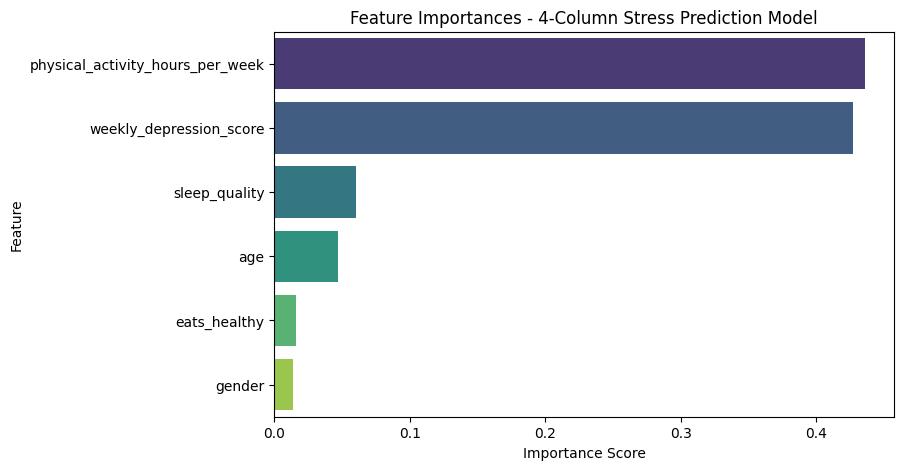


Feature Importance Rankings:
                            Feature  Importance
2  physical_activity_hours_per_week    0.435752
5           weekly_depression_score    0.427096
4                     sleep_quality    0.060023
0                               age    0.047378
3                      eats_healthy    0.015825
1                            gender    0.013926


In [242]:
#Visualizing Feature Importance

import seaborn as sns
import matplotlib.pyplot as plt

# Feature Importance
importances_sim = stress_predict_model.feature_importances_   #extracting importance values
feature_names_sim = X_sim_train.columns  #column names

#converting back into dataframe
feat_imp_sim_df = pd.DataFrame({
    "Feature": feature_names_sim,
    "Importance": importances_sim
}).sort_values(by="Importance", ascending=False)


plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=feat_imp_sim_df, palette="viridis")
plt.title("Feature Importances - 4-Column Stress Prediction Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

print("\nFeature Importance Rankings:")
print(feat_imp_sim_df)

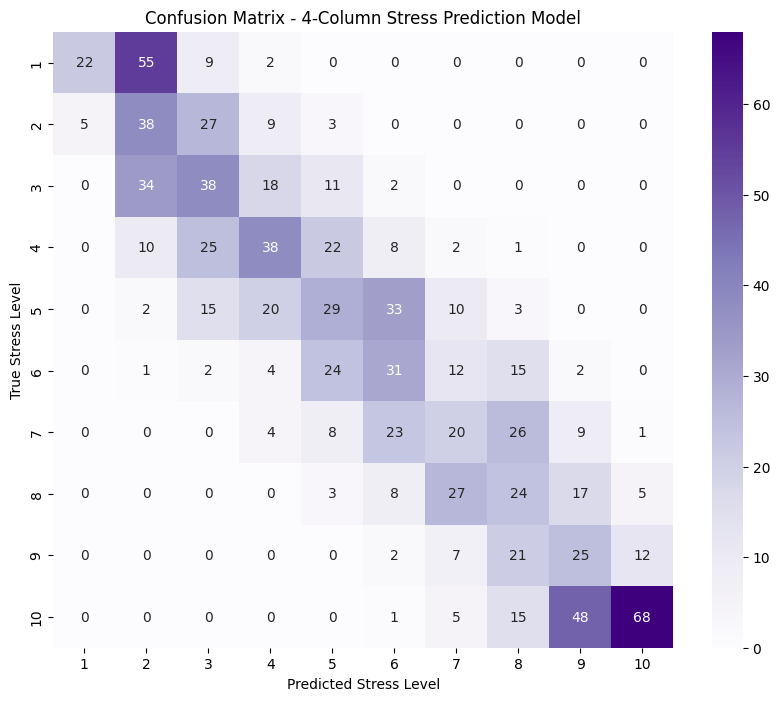

In [243]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


#confustion matrix for all features
cm_stress_sim = confusion_matrix(y_sim_test_rounded, y_sim_pred_rounded, labels=range(1,11))

plt.figure(figsize=(10,8))
sns.heatmap(cm_stress_sim, annot=True, fmt="d", cmap="Purples", 
            xticklabels=range(1,11), yticklabels=range(1,11))
plt.xlabel("Predicted Stress Level")
plt.ylabel("True Stress Level")
plt.title("Confusion Matrix - 4-Column Stress Prediction Model")
plt.show()

In [244]:
#Attempting to apply trained model to our Alz dataset
# Extracting similar columns
alz_cols_sim = ['Age', 'Gender', 'Depression', 'SleepQuality', 'DietQuality', 'PhysicalActivity']
alz_sim_df = df[alz_cols_sim].copy()
alz_sim_df

,Age,Gender,Depression,SleepQuality,DietQuality,PhysicalActivity
0,73,0,1,9.025679,1.347214,6.327112
1,89,0,0,7.151293,0.518767,7.619885
2,73,0,0,9.673574,1.826335,7.844988
3,74,1,0,8.392554,7.435604,8.428001
4,89,0,0,5.597238,0.795498,6.310461
...,...,...,...,...,...,...
2144,61,0,0,7.535540,6.555306,4.049964
2145,75,0,0,8.555256,2.904662,1.360667
2146,77,0,0,5.769464,8.120025,9.886002
2147,78,1,0,8.322874,1.263427,6.354282


In [245]:
#Scaling Columns

alz_sim_scaled = scaler.fit_transform(alz_sim_df)  #scaling data

#converting back into dataframe
alz_sim_df_scaled = pd.DataFrame(
    alz_sim_scaled,
    columns=alz_sim_df.columns,
    index=alz_sim_df.index
)


print("Original Alzheimer's data:")
print(alz_sim_df.head())
print("\nOriginal Alzheimer's data statistics:")
print(alz_sim_df.describe())

print("\nScaled Alzheimer's data:")
print(alz_sim_df_scaled.head())
print("\nScaled Alzheimer's data statistics:")
print(alz_sim_df_scaled.describe())

alz_sim_means = alz_sim_df_scaled.mean()  #averages
alz_sim_std = alz_sim_df_scaled.std()  #standard deviations

# Verify scaling worked (should have mean ~0 and std ~1)
print("\nScaled Alzheimer's data means (should be close to 0):")
print(alz_sim_means)
print("\nScaled Alzheimer's data standard deviations (should be close to 1):")
print(alz_sim_std)

alz_sim_df_scaled

Original Alzheimer's data:
   Age  Gender  Depression  SleepQuality  DietQuality  PhysicalActivity
0   73       0           1      9.025679     1.347214          6.327112
1   89       0           0      7.151293     0.518767          7.619885
2   73       0           0      9.673574     1.826335          7.844988
3   74       1           0      8.392554     7.435604          8.428001
4   89       0           0      5.597238     0.795498          6.310461

Original Alzheimer's data statistics:
               Age       Gender   Depression  SleepQuality  DietQuality  \
count  2149.000000  2149.000000  2149.000000   2149.000000  2149.000000   
mean     74.908795     0.506282     0.200558      7.051081     4.993138   
std       8.990221     0.500077     0.400511      1.763573     2.909055   
min      60.000000     0.000000     0.000000      4.002629     0.009385   
25%      67.000000     0.000000     0.000000      5.482997     2.458455   
50%      75.000000     1.000000     0.000000      7.

,Age,Gender,Depression,SleepQuality,DietQuality,PhysicalActivity
0,-0.212368,-1.012644,1.996517,1.119918,-1.253593,0.492525
1,1.567757,-1.012644,-0.500872,0.056836,-1.538442,0.945093
2,-0.212368,-1.012644,-0.500872,1.487380,-1.088855,1.023896
3,-0.101111,0.987514,-0.500872,0.760833,0.839804,1.227995
4,1.567757,-1.012644,-0.500872,-0.824566,-1.443293,0.486696
...,...,...,...,...,...,...
2144,-1.547463,-1.012644,-0.500872,0.274767,0.537127,-0.304649
2145,0.010147,-1.012644,-0.500872,0.853112,-0.718090,-1.246106
2146,0.232663,-1.012644,-0.500872,-0.726886,1.075131,1.738405
2147,0.343921,0.987514,-0.500872,0.721313,-1.282402,0.502036


In [246]:
#Using model on alzheimers data

#renaming columns so they match that of the model
alz_sim_df_scaled = alz_sim_df_scaled.rename(columns={
    'Age' : 'age',
    'Gender' : 'gender',
    'Depression': 'weekly_depression_score',
    'SleepQuality': 'sleep_quality',
    'DietQuality': 'eats_healthy',
    'PhysicalActivity': 'physical_activity_hours_per_week'
})


#applying model

X_alz = alz_sim_df_scaled[stress_predict_model.feature_names_in_]

#predictions
alz_stress_pred = stress_predict_model.predict(X_alz)
alz_stress_pred

array([ 0.2171223 , -1.0192183 , -0.90945846, ..., -0.48988864,
       -0.70595485, -1.0525507 ], shape=(2149,), dtype=float32)

In [247]:
#Unstandardizing values

alz_stress_pred_original = alz_stress_pred * stress_std + stress_mean 

alz_stress_pred_rounded = np.clip(np.round(alz_stress_pred_original), 1, 10)  #rounds predicted values to nearers integer, 1-10 scale
alz_stress_pred_rounded

array([6., 3., 3., ..., 4., 4., 3.], shape=(2149,))

In [248]:
#Inserting new stress column into Alzheimers Dataset

new_alz_df = df.copy()
new_alz_df["stress_score"] = alz_stress_pred_rounded  #new stress column
new_alz_df

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,Diabetes,Depression,HeadInjury,Hypertension,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,stress_score
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,0,0,1,1,0,0,142,72,242.366840,56.150897,33.682563,162.189143,21.463532,6.518877,0,0,1.725883,0,0,0,1,0,0,6.0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,0,0,0,0,0,0,115,64,231.162595,193.407996,79.028477,294.630909,20.613267,7.118696,0,0,2.592424,0,0,0,0,1,0,3.0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,1,0,0,0,0,0,99,116,284.181858,153.322762,69.772292,83.638324,7.356249,5.895077,0,0,7.119548,0,1,0,1,0,0,3.0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,0,0,0,0,0,0,118,115,159.582240,65.366637,68.457491,277.577358,13.991127,8.965106,0,1,6.481226,0,0,0,0,0,0,3.0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,0,0,0,0,0,0,94,117,237.602184,92.869700,56.874305,291.198780,13.517609,6.045039,0,0,0.014691,0,0,1,1,0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,61,0,0,1,39.121757,0,1.561126,4.049964,6.555306,7.535540,0,0,0,0,0,0,122,101,280.476824,94.870490,60.943092,234.520123,1.201190,0.238667,0,0,4.492838,1,0,0,0,0,1,7.0
2145,75,0,0,2,17.857903,0,18.767261,1.360667,2.904662,8.555256,0,0,0,0,0,0,152,106,186.384436,95.410700,93.649735,367.986877,6.458060,8.687480,0,1,9.204952,0,0,0,0,0,1,8.0
2146,77,0,0,1,15.476479,0,4.594670,9.886002,8.120025,5.769464,0,0,0,0,0,0,115,118,237.024558,156.267294,99.678209,294.802338,17.011003,1.972137,0,0,5.036334,0,0,0,0,0,1,4.0
2147,78,1,3,1,15.299911,0,8.674505,6.354282,1.263427,8.322874,0,1,0,0,0,0,103,96,242.197192,52.482961,81.281111,145.253746,4.030491,5.173891,0,0,3.785399,0,0,0,0,1,1,4.0


In [249]:
# Enhanced features: include stress_score
X_enhanced = new_alz_df.drop(columns=["Diagnosis"])   #features
y = new_alz_df["Diagnosis"]  #outcome variable

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_enhanced, y, test_size=0.2, stratify=y, random_state=42
)  #splitting data 80/20


final_xgb_enhanced = XGBClassifier(
    **best_params,   #best params from previous model
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

#fitting model
final_xgb_enhanced.fit(X_train_e, y_train_e)

y_pred_enhanced = final_xgb_enhanced.predict(X_test_e)  #predictions
y_pred_enhanced_prob = final_xgb_enhanced.predict_proba(X_test_e)[:,1]   #positive values


print("Enhanced Model (with stress)")
print("Accuracy:", accuracy_score(y_test_e, y_pred_enhanced))
print("ROC AUC:", roc_auc_score(y_test_e, y_pred_enhanced_prob))
print(classification_report(y_test_e, y_pred_enhanced))


c:\Users\patbe\Machine Leaning Project\ml_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:41:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Enhanced Model (with stress)
Accuracy: 0.9488372093023256
ROC AUC: 0.9431086709579705
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       278
           1       0.94      0.91      0.93       152

    accuracy                           0.95       430
   macro avg       0.95      0.94      0.94       430
weighted avg       0.95      0.95      0.95       430



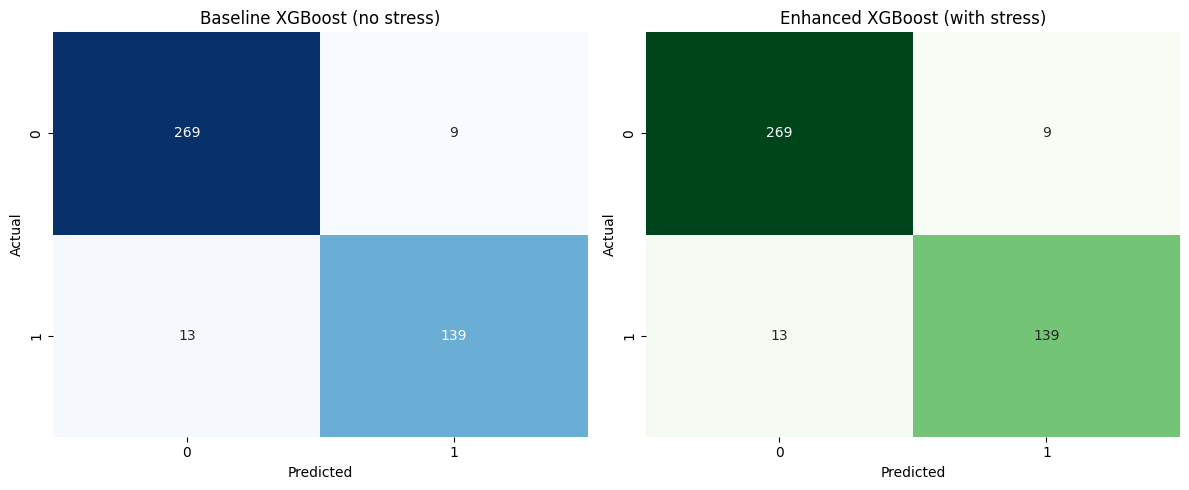

In [250]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#comparing confusion matrices
cm_base = confusion_matrix(y_test, y_pred_tuned)   # from baseline tuned XGB
cm_enhanced = confusion_matrix(y_test_e, y_pred_enhanced)  # from enhanced XGB

fig, axes = plt.subplots(1, 2, figsize=(12,5))

#base matrix
sns.heatmap(cm_base, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("Baseline XGBoost (no stress)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

#enhanced matrix
sns.heatmap(cm_enhanced, annot=True, fmt="d", cmap="Greens", cbar=False, ax=axes[1])
axes[1].set_title("Enhanced XGBoost (with stress)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [251]:
#scaling full alzheimer's dataframe
full_alz_scaled = scaler.fit_transform(new_alz_df)

full_alz_scaled = pd.DataFrame(
    full_alz_scaled,
    columns=new_alz_df.columns,
    index=new_alz_df.index
)
full_alz_scaled

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,Diabetes,Depression,HeadInjury,Hypertension,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,stress_score
0,-0.212368,-1.012644,-0.700408,0.788833,-0.655225,-0.636784,0.565923,0.492525,-1.253593,1.119918,-0.580753,-0.410573,2.373334,1.996517,-0.319455,-0.418281,0.298159,-1.014750,0.403677,-1.572661,-1.114429,-0.648199,0.779037,0.497506,-0.512477,-0.431257,-1.104434,-0.508131,-0.433531,-0.421348,2.302619,-0.657048,-0.739700,0.009776
1,1.567757,-1.012644,-0.700408,-1.422782,-0.114751,-0.636784,-0.954895,0.945093,-1.538442,0.056836,-0.580753,-0.410573,-0.421348,-0.500872,-0.319455,-0.418281,-0.742572,-1.469595,0.140248,1.593119,0.845730,0.650721,0.680297,0.704907,-0.512477,-0.431257,-0.810601,-0.508131,-0.433531,-0.421348,-0.434288,1.521959,-0.739700,-1.422579
2,-0.212368,-1.012644,2.311955,-0.316974,-1.366428,-0.636784,1.653006,1.023896,-1.088855,1.487380,1.721901,-0.410573,-0.421348,-0.500872,-0.319455,-0.418281,-1.359301,1.486898,1.386812,0.668569,0.445615,-1.418585,-0.859222,0.281813,-0.512477,-0.431257,0.724491,-0.508131,2.306640,-0.421348,2.302619,-0.657048,-0.739700,-1.422579
3,-0.101111,0.987514,-0.700408,-0.316974,0.851625,1.570391,0.376930,1.227995,0.839804,0.760833,-0.580753,-0.410573,-0.421348,-0.500872,-0.319455,-0.418281,-0.626935,1.430043,-1.542715,-1.360103,0.388780,0.483468,-0.088723,1.343346,-0.512477,2.318805,0.508044,-0.508131,-0.433531,-0.421348,-0.434288,-0.657048,-0.739700,-1.422579
4,1.567757,-1.012644,-0.700408,-1.422782,-0.961607,-0.636784,1.461793,0.486696,-1.443293,-0.824566,-0.580753,-0.410573,-0.421348,-0.500872,-0.319455,-0.418281,-1.552029,1.543754,0.291653,-0.725756,-0.111924,0.617060,-0.143712,0.333665,-0.512477,-0.431257,-1.684679,-0.508131,-0.433531,2.373334,2.302619,-0.657048,-0.739700,-0.945127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,-1.547463,-1.012644,-0.700408,-0.316974,1.589030,-0.636784,-1.472807,-0.304649,0.537127,0.274767,-0.580753,-0.410573,-0.421348,-0.500872,-0.319455,-0.418281,-0.472753,0.634063,1.299701,-0.679609,0.063957,0.061185,-1.574000,-1.674022,-0.512477,-0.431257,-0.166194,1.967998,-0.433531,-0.421348,-0.434288,-0.657048,1.351899,0.487227
2145,0.010147,-1.012644,-0.700408,0.788833,-1.357833,-0.636784,1.516149,-1.246106,-0.718090,0.853112,-0.580753,-0.410573,-0.421348,-0.500872,-0.319455,-0.418281,0.683615,0.918342,-0.912555,-0.667149,1.477761,1.370158,-0.963527,1.247350,-0.512477,2.318805,1.431627,-0.508131,-0.433531,-0.421348,-0.434288,-0.657048,1.351899,0.964678
2146,0.232663,-1.012644,-0.700408,-0.316974,-1.687864,-0.636784,-0.945836,1.738405,1.075131,-0.726886,-0.580753,-0.410573,-0.421348,-0.500872,-0.319455,-0.418281,-0.742572,1.600609,0.278072,0.736484,1.738352,0.652402,0.261971,-1.074634,-0.512477,-0.431257,0.018099,-0.508131,-0.433531,-0.421348,-0.434288,-0.657048,1.351899,-0.945127
2147,0.343921,0.987514,2.311955,-0.316974,-1.712334,-0.636784,-0.237109,0.502036,-1.282402,0.721313,-0.580753,2.435623,-0.421348,-0.500872,-0.319455,-0.418281,-1.205119,0.349785,0.399688,-1.657260,0.943104,-0.814293,-1.245437,0.032446,-0.512477,-0.431257,-0.406078,-0.508131,-0.433531,-0.421348,-0.434288,1.521959,1.351899,-0.945127


Attempting KMeans clustering

In [252]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score  # Silhouette metrics
from pandas.api.types import CategoricalDtype

# Run k-means
kmeans = KMeans(
    n_clusters=4, # Set Cluster number
    n_init=25, # Set number of starts
    max_iter=100, # Set max iterations
    random_state=1234, # Set random state
    algorithm="lloyd"   # classic Lloyd's algorithm
).fit(full_alz_scaled) # Fit to scaled data

kmeans.labels_


array([0, 1, 1, ..., 2, 2, 1], shape=(2149,), dtype=int32)

In [253]:
new_alz_df["cluster"] = kmeans.labels_

cluster_sizes = new_alz_df["cluster"].value_counts().sort_index() # Count samples in each cluster
print(cluster_sizes)
new_alz_df

cluster
0    430
1    628
2    575
3    516
Name: count, dtype: int64


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,Diabetes,Depression,HeadInjury,Hypertension,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,stress_score,cluster
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,0,0,1,1,0,0,142,72,242.366840,56.150897,33.682563,162.189143,21.463532,6.518877,0,0,1.725883,0,0,0,1,0,0,6.0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,0,0,0,0,0,0,115,64,231.162595,193.407996,79.028477,294.630909,20.613267,7.118696,0,0,2.592424,0,0,0,0,1,0,3.0,1
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,1,0,0,0,0,0,99,116,284.181858,153.322762,69.772292,83.638324,7.356249,5.895077,0,0,7.119548,0,1,0,1,0,0,3.0,1
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,0,0,0,0,0,0,118,115,159.582240,65.366637,68.457491,277.577358,13.991127,8.965106,0,1,6.481226,0,0,0,0,0,0,3.0,1
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,0,0,0,0,0,0,94,117,237.602184,92.869700,56.874305,291.198780,13.517609,6.045039,0,0,0.014691,0,0,1,1,0,0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,61,0,0,1,39.121757,0,1.561126,4.049964,6.555306,7.535540,0,0,0,0,0,0,122,101,280.476824,94.870490,60.943092,234.520123,1.201190,0.238667,0,0,4.492838,1,0,0,0,0,1,7.0,2
2145,75,0,0,2,17.857903,0,18.767261,1.360667,2.904662,8.555256,0,0,0,0,0,0,152,106,186.384436,95.410700,93.649735,367.986877,6.458060,8.687480,0,1,9.204952,0,0,0,0,0,1,8.0,3
2146,77,0,0,1,15.476479,0,4.594670,9.886002,8.120025,5.769464,0,0,0,0,0,0,115,118,237.024558,156.267294,99.678209,294.802338,17.011003,1.972137,0,0,5.036334,0,0,0,0,0,1,4.0,2
2147,78,1,3,1,15.299911,0,8.674505,6.354282,1.263427,8.322874,0,1,0,0,0,0,103,96,242.197192,52.482961,81.281111,145.253746,4.030491,5.173891,0,0,3.785399,0,0,0,0,1,1,4.0,2


In [254]:
full_alz_scaled

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,Diabetes,Depression,HeadInjury,Hypertension,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,stress_score
0,-0.212368,-1.012644,-0.700408,0.788833,-0.655225,-0.636784,0.565923,0.492525,-1.253593,1.119918,-0.580753,-0.410573,2.373334,1.996517,-0.319455,-0.418281,0.298159,-1.014750,0.403677,-1.572661,-1.114429,-0.648199,0.779037,0.497506,-0.512477,-0.431257,-1.104434,-0.508131,-0.433531,-0.421348,2.302619,-0.657048,-0.739700,0.009776
1,1.567757,-1.012644,-0.700408,-1.422782,-0.114751,-0.636784,-0.954895,0.945093,-1.538442,0.056836,-0.580753,-0.410573,-0.421348,-0.500872,-0.319455,-0.418281,-0.742572,-1.469595,0.140248,1.593119,0.845730,0.650721,0.680297,0.704907,-0.512477,-0.431257,-0.810601,-0.508131,-0.433531,-0.421348,-0.434288,1.521959,-0.739700,-1.422579
2,-0.212368,-1.012644,2.311955,-0.316974,-1.366428,-0.636784,1.653006,1.023896,-1.088855,1.487380,1.721901,-0.410573,-0.421348,-0.500872,-0.319455,-0.418281,-1.359301,1.486898,1.386812,0.668569,0.445615,-1.418585,-0.859222,0.281813,-0.512477,-0.431257,0.724491,-0.508131,2.306640,-0.421348,2.302619,-0.657048,-0.739700,-1.422579
3,-0.101111,0.987514,-0.700408,-0.316974,0.851625,1.570391,0.376930,1.227995,0.839804,0.760833,-0.580753,-0.410573,-0.421348,-0.500872,-0.319455,-0.418281,-0.626935,1.430043,-1.542715,-1.360103,0.388780,0.483468,-0.088723,1.343346,-0.512477,2.318805,0.508044,-0.508131,-0.433531,-0.421348,-0.434288,-0.657048,-0.739700,-1.422579
4,1.567757,-1.012644,-0.700408,-1.422782,-0.961607,-0.636784,1.461793,0.486696,-1.443293,-0.824566,-0.580753,-0.410573,-0.421348,-0.500872,-0.319455,-0.418281,-1.552029,1.543754,0.291653,-0.725756,-0.111924,0.617060,-0.143712,0.333665,-0.512477,-0.431257,-1.684679,-0.508131,-0.433531,2.373334,2.302619,-0.657048,-0.739700,-0.945127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,-1.547463,-1.012644,-0.700408,-0.316974,1.589030,-0.636784,-1.472807,-0.304649,0.537127,0.274767,-0.580753,-0.410573,-0.421348,-0.500872,-0.319455,-0.418281,-0.472753,0.634063,1.299701,-0.679609,0.063957,0.061185,-1.574000,-1.674022,-0.512477,-0.431257,-0.166194,1.967998,-0.433531,-0.421348,-0.434288,-0.657048,1.351899,0.487227
2145,0.010147,-1.012644,-0.700408,0.788833,-1.357833,-0.636784,1.516149,-1.246106,-0.718090,0.853112,-0.580753,-0.410573,-0.421348,-0.500872,-0.319455,-0.418281,0.683615,0.918342,-0.912555,-0.667149,1.477761,1.370158,-0.963527,1.247350,-0.512477,2.318805,1.431627,-0.508131,-0.433531,-0.421348,-0.434288,-0.657048,1.351899,0.964678
2146,0.232663,-1.012644,-0.700408,-0.316974,-1.687864,-0.636784,-0.945836,1.738405,1.075131,-0.726886,-0.580753,-0.410573,-0.421348,-0.500872,-0.319455,-0.418281,-0.742572,1.600609,0.278072,0.736484,1.738352,0.652402,0.261971,-1.074634,-0.512477,-0.431257,0.018099,-0.508131,-0.433531,-0.421348,-0.434288,-0.657048,1.351899,-0.945127
2147,0.343921,0.987514,2.311955,-0.316974,-1.712334,-0.636784,-0.237109,0.502036,-1.282402,0.721313,-0.580753,2.435623,-0.421348,-0.500872,-0.319455,-0.418281,-1.205119,0.349785,0.399688,-1.657260,0.943104,-0.814293,-1.245437,0.032446,-0.512477,-0.431257,-0.406078,-0.508131,-0.433531,-0.421348,-0.434288,1.521959,1.351899,-0.945127


In [ ]:
cols_to_scale = full_alz_scaled.columns

# Extract cluster centers into a dataframe
centers_df = (
    pd.DataFrame(kmeans.cluster_centers_, columns=cols_to_scale)
    .assign(cluster=np.arange(0, 4))
    .loc[:, ["cluster"] + cols_to_scale.tolist()]
)
# Convert data to long form
center_long = (
    centers_df
    .melt(id_vars=["cluster"], var_name="features", value_name="values")
    .copy()
)
# Order variables alphabetically
sorted_features = sorted([c for c in centers_df.columns if c != "cluster"])
# Make 'features' an ordered categorical (so plot keeps our chosen order)
center_long["features"] = center_long["features"].astype(
    CategoricalDtype(categories=sorted_features, ordered=True)
)
# Turn off dark mode
plt.style.use('default')
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    "figure.facecolor": "white",   # ensure white figure background
    "axes.facecolor": "white",     # ensure white axes background
    "savefig.facecolor": "white",  # ensure saved figures are white
})


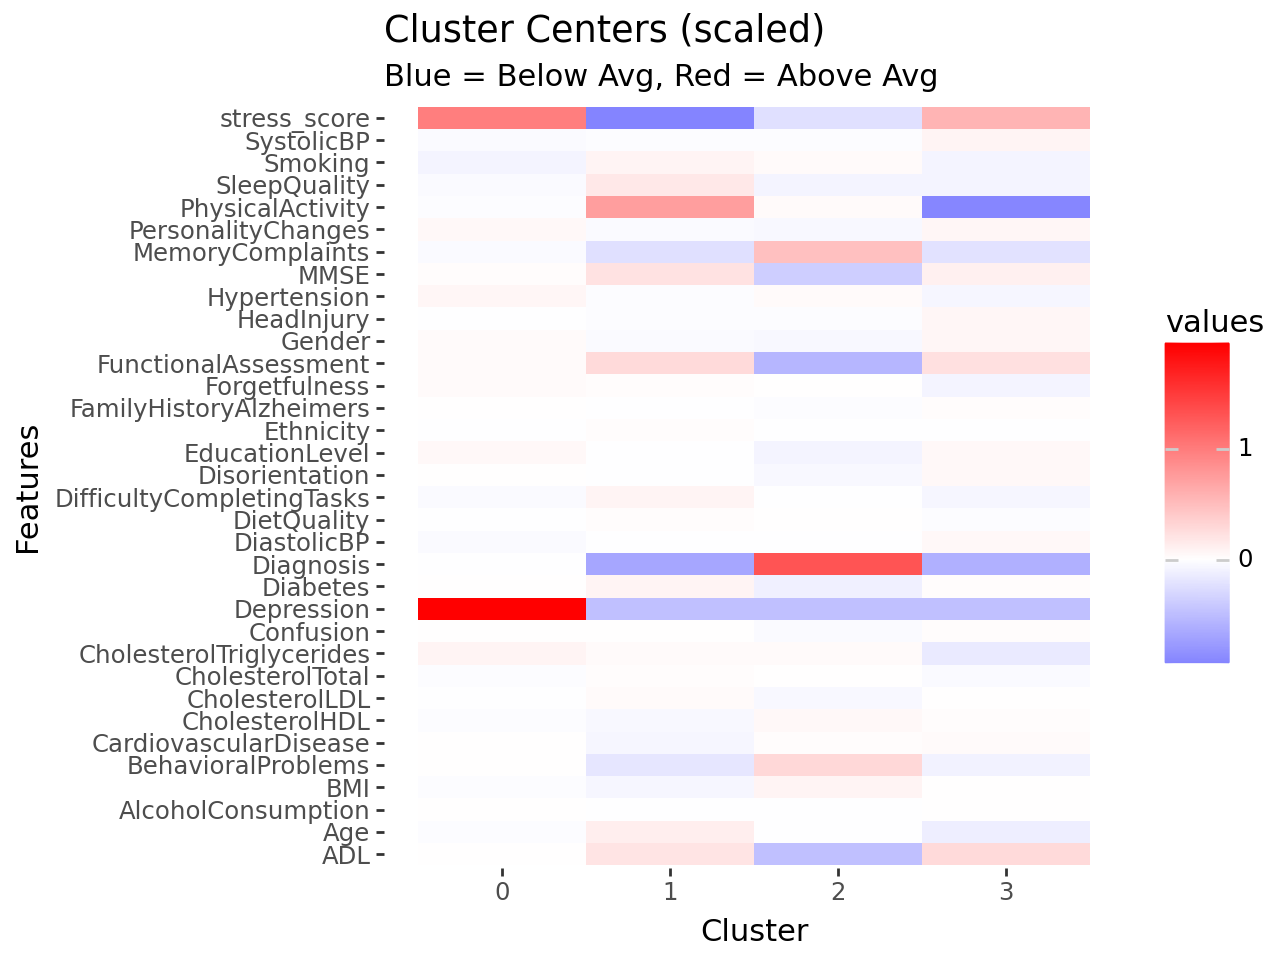

In [256]:
# Generate plot
g_heat_1 = (
    ggplot(data=center_long,                           # Set dataset
           mapping=aes(x="features", y="cluster", fill="values"))
    + scale_y_continuous(breaks=list(range(0, 4)))     # Set y axis breaks
    + geom_tile()                                        # Geom tile for heatmap
    + theme_bw()                             # Set theme
    + scale_fill_gradient2(                              # Diverging fill (centered at 0)
        low="blue", mid="white", high="red",
        midpoint=0, na_value="grey"         # Set midpoints
        # guide defaults to a colorbar in plotnine
    )
    + theme(                                             # Modify plot elements
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank()
    )
    + labs(                                              # Add labels
        x="Features",
        y="Cluster",
        title="Cluster Centers (scaled)",
        subtitle="Blue = Below Avg, Red = Above Avg"
    )
    + coord_flip()                                       # Rotate plot to view names clearly
)

# Generate plot
g_heat_1

In [257]:
# Run k-means with more clusters
kmeans = KMeans(
    n_clusters=6, # Set Cluster number
    n_init=25, # Set number of starts
    max_iter=100, # Set max iterations
    random_state=1234, # Set random state
    algorithm="lloyd"   # classic Lloyd's algorithm
).fit(full_alz_scaled) # Fit to scaled data

kmeans.labels_

new_alz_df["cluster"] = kmeans.labels_

cluster_sizes = new_alz_df["cluster"].value_counts().sort_index() # Count samples in each cluster
print(cluster_sizes)



cluster
0    271
1    405
2    369
3    199
4    461
5    444
Name: count, dtype: int64


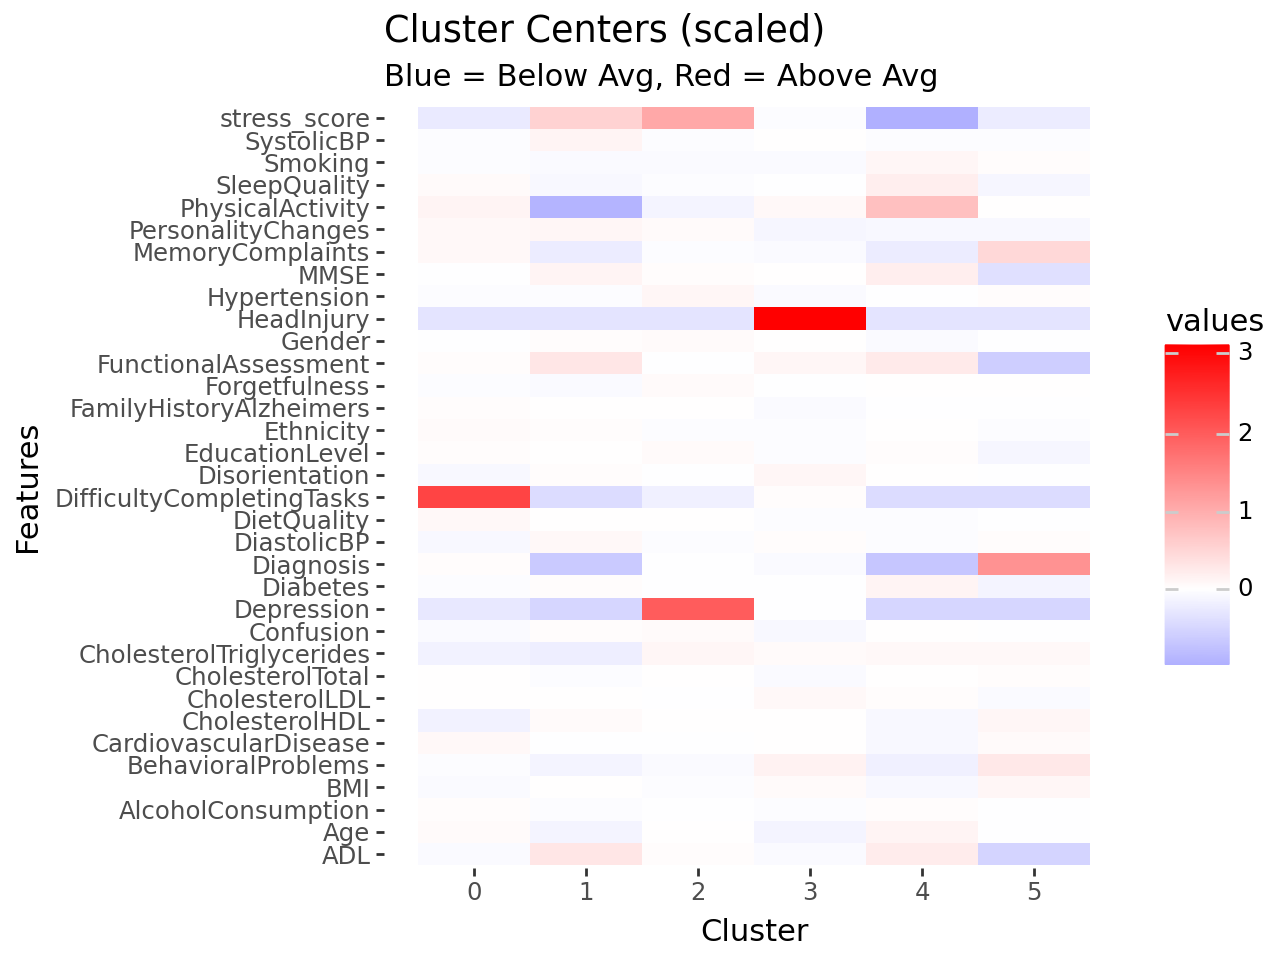

In [258]:
cols_to_scale = full_alz_scaled.columns

# Extract cluster centers
centers_df = (
    pd.DataFrame(kmeans.cluster_centers_, columns=cols_to_scale)
    .assign(cluster=np.arange(0, 6))
    .loc[:, ["cluster"] + cols_to_scale.tolist()]
)
# Convert data to long form
center_long = (
    centers_df
    .melt(id_vars=["cluster"], var_name="features", value_name="values")
    .copy()
)
# Order variables alphabetically
sorted_features = sorted([c for c in centers_df.columns if c != "cluster"])
# Make 'features' an ordered categorical (so plot keeps our chosen order)
center_long["features"] = center_long["features"].astype(
    CategoricalDtype(categories=sorted_features, ordered=True)
)
# Turn off dark mode
plt.style.use('default')
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    "figure.facecolor": "white",   # ensure white figure background
    "axes.facecolor": "white",     # ensure white axes background
    "savefig.facecolor": "white",  # ensure saved figures are white
})


# Generate plot
g_heat_1 = (
    ggplot(data=center_long,                           # Set dataset
           mapping=aes(x="features", y="cluster", fill="values"))
    + scale_y_continuous(breaks=list(range(0, 6)))     # Set y axis breaks
    + geom_tile()                                        # Geom tile for heatmap
    + theme_bw()                             # Set theme
    + scale_fill_gradient2(                              # Diverging fill (centered at 0)
        low="blue", mid="white", high="red",
        midpoint=0, na_value="grey"         # Set midpoints
        # guide defaults to a colorbar in plotnine
    )
    + theme(                                             # Modify plot elements
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank()
    )
    + labs(                                              # Add labels
        x="Features",
        y="Cluster",
        title="Cluster Centers (scaled)",
        subtitle="Blue = Below Avg, Red = Above Avg"
    )
    + coord_flip()                                       # Rotate plot to view names clearly
)

# Generate plot
g_heat_1

In [259]:
# Crosstab of Diagnosis by Cluster
cluster_diagnosis_ct = pd.crosstab(new_alz_df["cluster"], new_alz_df["Diagnosis"])
print(cluster_diagnosis_ct)

# Normalize to see proportions
cluster_diagnosis_pct = cluster_diagnosis_ct.div(cluster_diagnosis_ct.sum(axis=1), axis=0)
print(cluster_diagnosis_pct)

Diagnosis    0    1
cluster            
0          170  101
1          390   15
2          242  127
3          135   64
4          450   11
5            2  442
Diagnosis         0         1
cluster                      
0          0.627306  0.372694
1          0.962963  0.037037
2          0.655827  0.344173
3          0.678392  0.321608
4          0.976139  0.023861
5          0.004505  0.995495


In [260]:
# Get descriptive stats for each cluster
cluster_summary = new_alz_df.groupby("cluster").mean(numeric_only=True)
cluster_summary


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,Diabetes,Depression,HeadInjury,Hypertension,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,stress_score
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,75.531365,0.505535,0.760148,1.313653,27.271361,0.276753,10.303955,5.332900,5.226684,7.139957,0.273063,0.173432,0.140221,0.084871,0.0,0.132841,133.280443,88.431734,225.493709,124.604711,55.895223,211.575971,14.721082,5.166924,0.239852,0.147601,4.832685,0.184502,0.125461,0.180812,1.000000,0.284133,0.372694,5.457565
1,73.711111,0.520988,0.723457,1.301235,27.830399,0.259259,9.855981,2.324410,5.010920,6.894801,0.261728,0.140741,0.165432,0.000000,0.0,0.133333,137.898765,91.567901,224.131080,124.347431,60.897701,207.144154,15.921430,5.935885,0.113580,0.111111,5.920629,0.217284,0.170370,0.192593,0.004938,0.274074,0.037037,7.128395
2,74.967480,0.531165,0.672087,1.349593,27.435000,0.265583,9.976136,4.551560,5.018750,6.976677,0.254743,0.138211,0.149051,1.000000,0.0,0.184282,133.452575,89.176152,225.533526,123.788888,59.818475,238.950247,14.985452,5.064910,0.192412,0.138211,5.104368,0.233062,0.154472,0.173442,0.092141,0.333333,0.344173,8.238482
3,73.773869,0.512563,0.668342,1.261307,28.023602,0.261307,9.889855,5.150725,4.918820,7.025988,0.226131,0.145729,0.150754,0.190955,1.0,0.130653,134.271357,90.422111,222.303878,127.974108,59.513112,233.658006,14.918571,5.393790,0.180905,0.211055,4.829078,0.165829,0.195980,0.115578,0.170854,0.301508,0.321608,5.909548
4,76.199566,0.481562,0.715835,1.316703,26.993060,0.334056,10.280152,7.118039,4.901321,7.398187,0.249458,0.117137,0.195228,0.000000,0.0,0.140998,133.379610,88.997831,225.537833,125.618303,57.439123,238.272346,16.602895,5.796814,0.108460,0.093275,5.689856,0.206074,0.160521,0.123644,0.000000,0.305857,0.023861,3.947939
5,74.740991,0.495495,0.650901,1.184685,28.437455,0.306306,9.915069,4.957154,4.941726,6.852074,0.243243,0.162162,0.099099,0.002252,0.0,0.159910,133.141892,90.326577,226.653832,121.653993,62.118008,236.108850,11.528883,3.374146,0.403153,0.261261,3.453476,0.200450,0.150901,0.119369,0.000000,0.306306,0.995495,5.513514


In [ ]:
#cluster averages
cluster_diag_summary = new_alz_df.groupby(["cluster", "Diagnosis"]).mean(numeric_only=True)
print(cluster_diag_summary)


                         Age    Gender  Ethnicity  EducationLevel        BMI  \
cluster Diagnosis                                                              
0       0          75.923529  0.511765   0.717647        1.341176  27.055282   
        1          74.871287  0.495050   0.831683        1.267327  27.635058   
1       0          73.715385  0.523077   0.735897        1.292308  27.995296   
        1          73.600000  0.466667   0.400000        1.533333  23.543060   
2       0          74.685950  0.528926   0.673554        1.338843  27.373881   
        1          75.503937  0.535433   0.669291        1.370079  27.551463   
3       0          73.666667  0.570370   0.711111        1.303704  28.211082   
        1          74.000000  0.390625   0.578125        1.171875  27.628137   
4       0          76.226667  0.482222   0.702222        1.315556  27.111584   
        1          75.090909  0.454545   1.272727        1.363636  22.144336   
5       0          61.000000  0.500000  

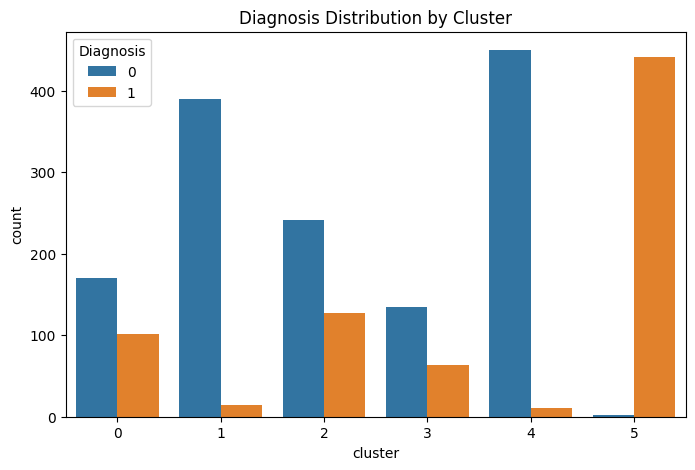

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


#graphic cluster distributions
plt.figure(figsize=(8,5))
sns.countplot(data=new_alz_df, x="cluster", hue="Diagnosis")
plt.title("Diagnosis Distribution by Cluster")
plt.show()


In [263]:
# Crosstab of diagnosis per cluster
cluster_diagnosis_ct = pd.crosstab(new_alz_df["cluster"], new_alz_df["Diagnosis"])

# Calculate prevalence (% Alzheimer’s)
cluster_diagnosis_ct["Alzheimers_Prevalence"] = (
    cluster_diagnosis_ct[1] / cluster_diagnosis_ct.sum(axis=1) * 100
)

print(cluster_diagnosis_ct)


Diagnosis    0    1  Alzheimers_Prevalence
cluster                                   
0          170  101              37.269373
1          390   15               3.703704
2          242  127              34.417344
3          135   64              32.160804
4          450   11               2.386117
5            2  442              99.549550


In [264]:
# Overall prevalence
overall_prevalence = (new_alz_df["Diagnosis"].mean()) * 100

# Label clusters as High-Risk if prevalence is above overall average
cluster_diagnosis_ct["Risk_Level"] = np.where(
    cluster_diagnosis_ct["Alzheimers_Prevalence"] > overall_prevalence,
    "High-Risk",
    "Lower-Risk"
)

print("Overall Alzheimer’s prevalence:", round(overall_prevalence, 2), "%")
print(cluster_diagnosis_ct)


Overall Alzheimer’s prevalence: 35.37 %
Diagnosis    0    1  Alzheimers_Prevalence  Risk_Level
cluster                                               
0          170  101              37.269373   High-Risk
1          390   15               3.703704  Lower-Risk
2          242  127              34.417344  Lower-Risk
3          135   64              32.160804  Lower-Risk
4          450   11               2.386117  Lower-Risk
5            2  442              99.549550   High-Risk


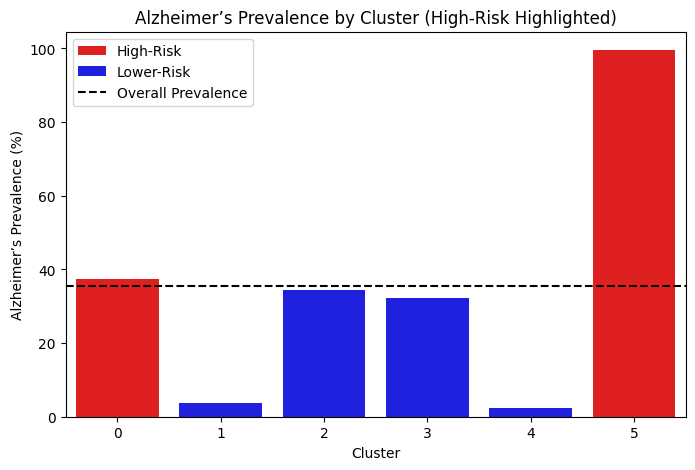

In [ ]:

#plotting prevalence
plt.figure(figsize=(8,5))
sns.barplot(
    x=cluster_diagnosis_ct.index,
    y=cluster_diagnosis_ct["Alzheimers_Prevalence"],
    hue=cluster_diagnosis_ct["Risk_Level"],
    palette={"High-Risk": "red", "Lower-Risk": "blue"}
)
plt.axhline(overall_prevalence, color="black", linestyle="--", label="Overall Prevalence")
plt.title("Alzheimer’s Prevalence by Cluster (High-Risk Highlighted)")
plt.xlabel("Cluster")
plt.ylabel("Alzheimer’s Prevalence (%)")
plt.legend()
plt.show()


In [266]:
high_risk_clusters = cluster_diagnosis_ct.query("Risk_Level == 'High-Risk'").index
high_risk_summary = new_alz_df[new_alz_df["cluster"].isin(high_risk_clusters)].groupby("cluster").mean(numeric_only=True)
print(high_risk_summary)


               Age    Gender  Ethnicity  EducationLevel        BMI   Smoking  \
cluster                                                                        
0        75.531365  0.505535   0.760148        1.313653  27.271361  0.276753   
5        74.740991  0.495495   0.650901        1.184685  28.437455  0.306306   

         AlcoholConsumption  PhysicalActivity  DietQuality  SleepQuality  \
cluster                                                                    
0                 10.303955          5.332900     5.226684      7.139957   
5                  9.915069          4.957154     4.941726      6.852074   

         FamilyHistoryAlzheimers  CardiovascularDisease  Diabetes  Depression  \
cluster                                                                         
0                       0.273063               0.173432  0.140221    0.084871   
5                       0.243243               0.162162  0.099099    0.002252   

         HeadInjury  Hypertension  SystolicBP  Di